In [57]:
# Import Dependencies
import pandas as pd

# Kaggle API
from kaggle.api.kaggle_api_extended import KaggleApi
import os
import json

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Defining a variable to store the dataset from kaggle to access
source = "alopez247/pokemon"

# Visuals
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer

# Removing warnings
import warnings


In [ ]:
# Accessing Data from Kaggle

# Load Kaggle API key from [redacted]
with open("secrets/kaggle.json") as f:
    kaggle_credentials = json.load(f)

# Set enviro variables for API
os.environ["KAGGLE_USERNAME"] = kaggle_credentials["username"]
os.environ["KAGGLE_KEY"] = kaggle_credentials["key"]

# Kaggle API:
api = KaggleApi()
api.authenticate()

# Accessing Dataset
path = api.dataset_download_files(source, unzip= True, path= "data")


Dataset URL: https://www.kaggle.com/datasets/alopez247/pokemon


In [31]:
# Creating the dataframe!

df = pd.read_csv("data/pokemon_alopez247.csv", index_col= 0)
print(df.head(6))

              Name Type_1  Type_2  Total  HP  Attack  Defense  Sp_Atk  Sp_Def  \
Number                                                                          
1        Bulbasaur  Grass  Poison    318  45      49       49      65      65   
2          Ivysaur  Grass  Poison    405  60      62       63      80      80   
3         Venusaur  Grass  Poison    525  80      82       83     100     100   
4       Charmander   Fire     NaN    309  39      52       43      60      50   
5       Charmeleon   Fire     NaN    405  58      64       58      80      65   
6        Charizard   Fire  Flying    534  78      84       78     109      85   

        Speed  ...  Color  hasGender Pr_Male  Egg_Group_1  Egg_Group_2  \
Number         ...                                                       
1          45  ...  Green       True   0.875      Monster        Grass   
2          60  ...  Green       True   0.875      Monster        Grass   
3          80  ...  Green       True   0.875      Monst

In [32]:
# Grabbing the columns to know what I need to remove/encode
col_list = df.columns.tolist()

# Removing name for the model
col_list = [item for item in col_list if item not in ["Name"]]
print(col_list)
print(df.info())


['Type_1', 'Type_2', 'Total', 'HP', 'Attack', 'Defense', 'Sp_Atk', 'Sp_Def', 'Speed', 'Generation', 'isLegendary', 'Color', 'hasGender', 'Pr_Male', 'Egg_Group_1', 'Egg_Group_2', 'hasMegaEvolution', 'Height_m', 'Weight_kg', 'Catch_Rate', 'Body_Style']
<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Name              721 non-null    object 
 1   Type_1            721 non-null    object 
 2   Type_2            350 non-null    object 
 3   Total             721 non-null    int64  
 4   HP                721 non-null    int64  
 5   Attack            721 non-null    int64  
 6   Defense           721 non-null    int64  
 7   Sp_Atk            721 non-null    int64  
 8   Sp_Def            721 non-null    int64  
 9   Speed             721 non-null    int64  
 10  Generation        721 non-null    int64  
 11  isLegendary       721 non-null   

In [39]:
# Prepping the data for clustering

# Creating Cluster DF
df_cluster = df[col_list]

# Encoding categorical data

# Encoding pokemon types
# NANs
df_cluster["Type_2"].fillna("None")
types_combined = pd.concat([df_cluster["Type_1"], df_cluster["Type_2"]]).unique() 
# Label encoding types
le = LabelEncoder() 
le.fit(types_combined)

df_cluster["Type_1_Encoded"] = le.transform(df_cluster["Type_1"])
df_cluster["Type_2_Encoded"] = le.transform(df_cluster["Type_2"])
df_cluster = df_cluster.drop(columns= ["Type_1", "Type_2"])
df_cluster

# Bool encoding
bool_cols = ["isLegendary", "hasGender", "hasMegaEvolution"]
df_cluster[bool_cols] = df_cluster[bool_cols].astype(int)

# Cat encoding
cat_cols = ["Color", "Egg_Group_1", "Egg_Group_2", "Body_Style"]
for col in cat_cols:
    df_cluster[col] = df_cluster[col].fillna("None")
    le = LabelEncoder()
    df_cluster[col + "_Encoded"] = le.fit_transform(df_cluster[col])
df_cluster = df_cluster.drop(columns= cat_cols)

# Fixing gender percentage for pokemon without genders

df_cluster["Pr_Male"] = df_cluster["Pr_Male"].fillna(-1)

df_cluster.head(3)

,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,...,hasMegaEvolution,Height_m,Weight_kg,Catch_Rate,Type_1_Encoded,Type_2_Encoded,Color_Encoded,Egg_Group_1_Encoded,Egg_Group_2_Encoded,Body_Style_Encoded
Number,,,,,,,,,,,,,,,,,,,,,
1,318,45,49,49,65,65,45,1,0,1,...,0,0.71,6.9,45,9,13,3,10,6,9
2,405,60,62,63,80,80,60,1,0,1,...,0,0.99,13.0,45,9,13,3,10,6,9
3,525,80,82,83,100,100,80,1,0,1,...,1,2.01,100.0,45,9,13,3,10,6,9


In [40]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Index: 721 entries, 1 to 721
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Total                721 non-null    int64  
 1   HP                   721 non-null    int64  
 2   Attack               721 non-null    int64  
 3   Defense              721 non-null    int64  
 4   Sp_Atk               721 non-null    int64  
 5   Sp_Def               721 non-null    int64  
 6   Speed                721 non-null    int64  
 7   Generation           721 non-null    int64  
 8   isLegendary          721 non-null    int32  
 9   hasGender            721 non-null    int32  
 10  Pr_Male              721 non-null    float64
 11  hasMegaEvolution     721 non-null    int32  
 12  Height_m             721 non-null    float64
 13  Weight_kg            721 non-null    float64
 14  Catch_Rate           721 non-null    int64  
 15  Type_1_Encoded       721 non-null    int32  


In [42]:
# Scaling!

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

In [52]:
# Silhouette Scores for determining clusters

# Suppress future and user warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Lists
sil_scores = []
k_values = range(2,10)

for k in k_values:
    kmeans = KMeans(n_clusters= k, random_state= 42, n_init= 10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k = {k}, silhouette score: {score:.4f}")


k = 2, silhouette score: 0.1576
k = 3, silhouette score: 0.1609
k = 4, silhouette score: 0.1672
k = 5, silhouette score: 0.1351
k = 6, silhouette score: 0.1243
k = 7, silhouette score: 0.1304
k = 8, silhouette score: 0.1389
k = 9, silhouette score: 0.1109


### The best no. of clusters returned a silhouette score of .167. (4) 

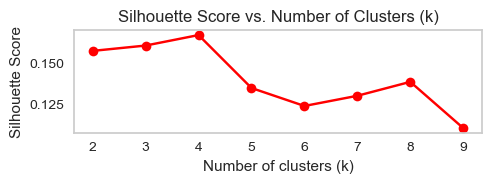

In [61]:
# Plotting the silhouette scores
plt.figure(figsize=(5, 2))
plt.plot(k_values, sil_scores, marker='o', linestyle='-', color='red')
plt.title("Silhouette Score vs. Number of Clusters (k)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.xticks(k_values)
plt.grid(False)
plt.tight_layout()
plt.show()

In [ ]:
# Testing yellowbrick for visualizing silhouette scores
